# Train a deep SNN on the SHD Dataset

In [1]:
import os
import sys

sys.path.append("../../stork")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns


import stork
from stork.datasets import HDF5Dataset, DatasetView

from stork.loss_stacks import MeanOfSoftmaxCrossEntropy, SumOfSoftmaxCrossEntropy
from stork.layers import Layer
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import (
    FluctuationDrivenCenteredNormalInitializer,
    DistInitializer,
)

using delay stork version - filter cascades


# TEST SOFTMAX

In [2]:
b = 256
t = 350
n = 20

x = torch.randn((b, t, n))

torch.nn.Softmax(dim=-1)(x).sum(dim=-1)

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

## Load Dataset

***To locally run this notebook on your system, download the SHD dataset from: [https://zenkelab.org/datasets/](https://zenkelab.org/datasets/).***
*We need 'shd_train.h5' and 'shd_test.h5'. Move the downloaded files into a folder `data/datasets/hdspikes` in this repo, or change the `datadir` variable below. 

In [3]:
datadir = "/tungstenfs/scratch/gzenke/datasets/hdspikes"

Next, we specify the Dataset Parameters.

In [4]:
nb_inputs = 700
duration = 0.7
time_step = dt = 2e-3
nb_time_steps = int(duration / time_step)
time_scale = 1
unit_scale = 1
validation_split = 0.9

sigma_u_augment = 10
dropout_p = 0.4

In [5]:
train_gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None,
    sigma_u_uniform=sigma_u_augment,
)

test_gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None,
    sigma_u_uniform=0,
)

In [6]:
train_dataset = HDF5Dataset(os.path.join(datadir, "shd_train.h5"), **train_gen_kwargs)

# Split into train and validation set
mother_dataset = train_dataset
elements = np.arange(len(mother_dataset))
np.random.shuffle(elements)
split = int(validation_split * len(mother_dataset))
valid_dataset = DatasetView(mother_dataset, elements[split:])
train_dataset = DatasetView(mother_dataset, elements[:split])

test_dataset = HDF5Dataset(os.path.join(datadir, "shd_test.h5"), **test_gen_kwargs)

## Set up the model

In [7]:
# Model Parameters
batch_size = 256
beta = 20
device = torch.device("cuda:1")
dtype = torch.float
dropout_p = 0.4

nb_hidden_units = 1024
nb_hidden_layers = 1
nb_classes = 20

tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = 200e-3

lr = 5e-3
nb_epochs = 150

In [8]:
act_fn = stork.activations.SuperSpike
act_fn.beta = beta
neuron_group = LIFGroup

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Create regularizers

In [9]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0
upperBoundL2Threshold = (
    7  # Regularizes spikecount: 7 spikes ~ 10 Hz in 700ms simulation time
)
weightL2Strength = 1e-4

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(
    lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
)
regs.append(regLB)
regUB = stork.regularizers.UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1
)
regs.append(regUB)

w_regs = []

regw = stork.regularizers.WeightL2Regularizer(strength=weightL2Strength)
w_regs.append(regw)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [10]:
sigma_u = 0.1
nu = 15.8

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u, nu=nu, timestep=dt
)

readout_initializer = DistInitializer()

Add input neuron group

In [11]:
input_group = model.add_group(InputGroup(nb_inputs, dropout_p=dropout_p))

Now we want to add multiple hidden layers as well as regularizers for them

In [12]:
upstream_group = input_group

for l in range(nb_hidden_layers):

    hidden_layer = Layer(
        "hidden",
        model,
        nb_hidden_units,
        upstream_group,
        recurrent=True,
        regs=regs,
        w_regs=w_regs,
        neuron_kwargs=dict(
            tau_mem=tau_mem, tau_syn=tau_syn, activation=act_fn, dropout_p=dropout_p
        ),
    )

    upstream_group = hidden_layer.output_group

    initializer.initialize(hidden_layer)

readout_group = model.add_group(
    ReadoutGroup(nb_classes, tau_mem=tau_readout, tau_syn=tau_syn, initial_state=-1e-2)
)

con_ro = model.add_connection(Connection(upstream_group, readout_group))
readout_initializer.initialize(con_ro)

Add monitors for spikes and membrane potential

In [13]:
for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1 + i]))

for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.StateMonitor(model.groups[1 + i], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [14]:
loss_stack = SumOfSoftmaxCrossEntropy()

We select the SMORMS3 optimizer

In [15]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
scheduler_kwargs = {
    "T_max": nb_epochs,
}
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
scheduler_kwargs = {
    "T_0": 10,
    "T_mult": 2,
    "eta_min": lr * 0.01,
    "last_epoch": -1,
}
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [16]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    time_step=dt,
)

Before we train the model, we monitor the spikes (ca. 20s)

In [17]:
# Monitors spike counts before training
results = {}
res = model.monitor(test_dataset)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(nb_hidden_layers)]
results["avg_layer_freq_init"] = [
    nb / len(test_dataset) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

print(results)

{'avg_layer_freq_init': [0.05471966592787734]}


In [18]:
model.groups[1].get_flattened_out_sequence().shape

torch.Size([216, 349, 1024])

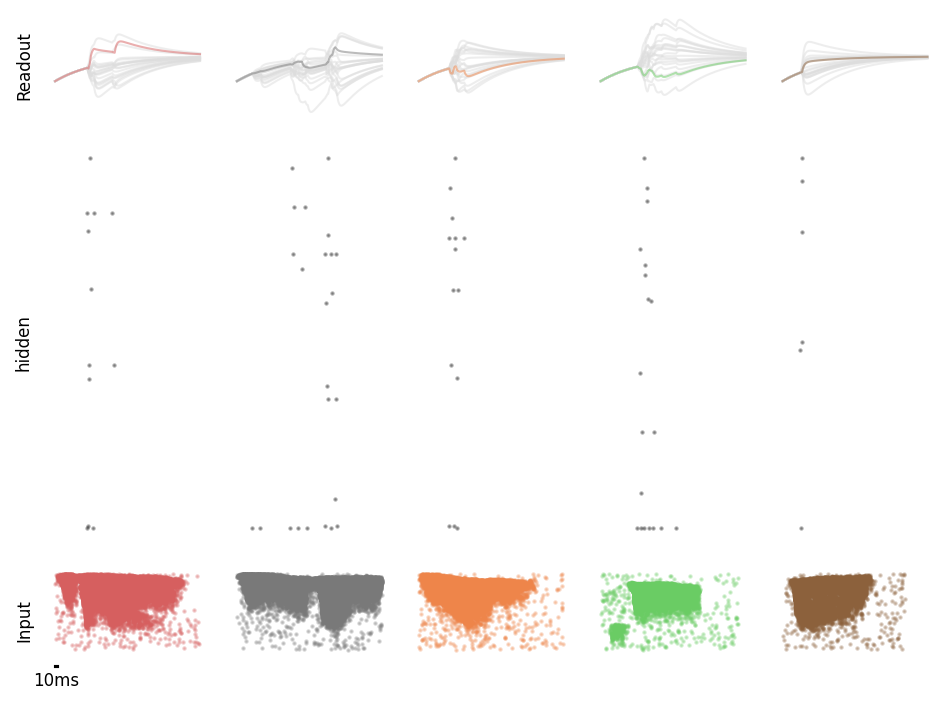

In [19]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model, data=test_dataset, nb_samples=5, point_alpha=0.3
)

## Train

It takes around 50 min using a powerful GPU

In [56]:
history = model.fit_validate(
    train_dataset, valid_dataset, nb_epochs=50, verbose=True
)

00  loss=0.119 reg_loss=1.39e-05 acc=0.973 -- val_loss=0.0574 val_reg_loss=1.48e-05 val_acc=0.986 t_iter=10.14
01  loss=0.0888 reg_loss=1.39e-05 acc=0.974 -- val_loss=0.0471 val_reg_loss=1.48e-05 val_acc=0.993 t_iter=10.06
02  loss=0.127 reg_loss=1.38e-05 acc=0.969 -- val_loss=0.046 val_reg_loss=1.48e-05 val_acc=0.988 t_iter=9.93
03  loss=0.108 reg_loss=1.38e-05 acc=0.974 -- val_loss=0.036 val_reg_loss=1.47e-05 val_acc=0.988 t_iter=10.03
04  loss=0.091 reg_loss=1.37e-05 acc=0.975 -- val_loss=0.0433 val_reg_loss=1.46e-05 val_acc=0.989 t_iter=9.93
05  loss=0.105 reg_loss=1.37e-05 acc=0.973 -- val_loss=0.0473 val_reg_loss=1.47e-05 val_acc=0.99 t_iter=10.05
06  loss=0.0959 reg_loss=1.37e-05 acc=0.976 -- val_loss=0.045 val_reg_loss=1.45e-05 val_acc=0.987 t_iter=9.93
07  loss=0.0988 reg_loss=1.36e-05 acc=0.975 -- val_loss=0.0528 val_reg_loss=1.45e-05 val_acc=0.982 t_iter=10.05
08  loss=0.105 reg_loss=1.36e-05 acc=0.975 -- val_loss=0.0372 val_reg_loss=1.46e-05 val_acc=0.994 t_iter=10.16
09  l

In [ ]:
if "train_loss" in results:
    results["train_loss"] += history["loss"].tolist()
    results["train_acc"] += history["acc"].tolist()
    results["valid_loss"] += history["val_loss"].tolist()
    results["valid_acc"] += history["val_acc"].tolist()
else:
    results["train_loss"] = history["loss"].tolist()
    results["train_acc"] = history["acc"].tolist()
    results["valid_loss"] = history["val_loss"].tolist()
    results["valid_acc"] = history["val_acc"].tolist()

Monitor the model again after training

In [ ]:
res = model.monitor(test_dataset)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(nb_hidden_layers)]
results["avg_layer_freq"] = [
    nb / len(test_dataset) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

print(results["avg_layer_freq"])

[27.573439373264765]


## Test

In [ ]:
scores = model.evaluate(test_dataset).tolist()
results["test_loss"], _, results["test_acc"] = scores

Test loss:  0.5351595514350467
Test acc.:  0.9293016975308643


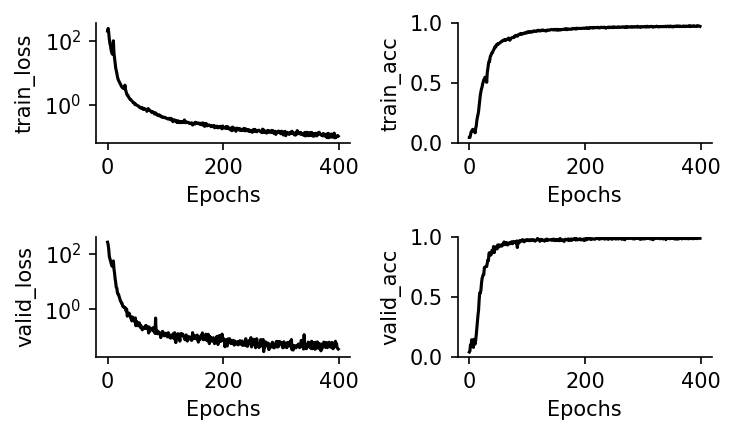

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):

    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

    if "loss" in n:
        a.set_yscale("log")

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", results["test_acc"])

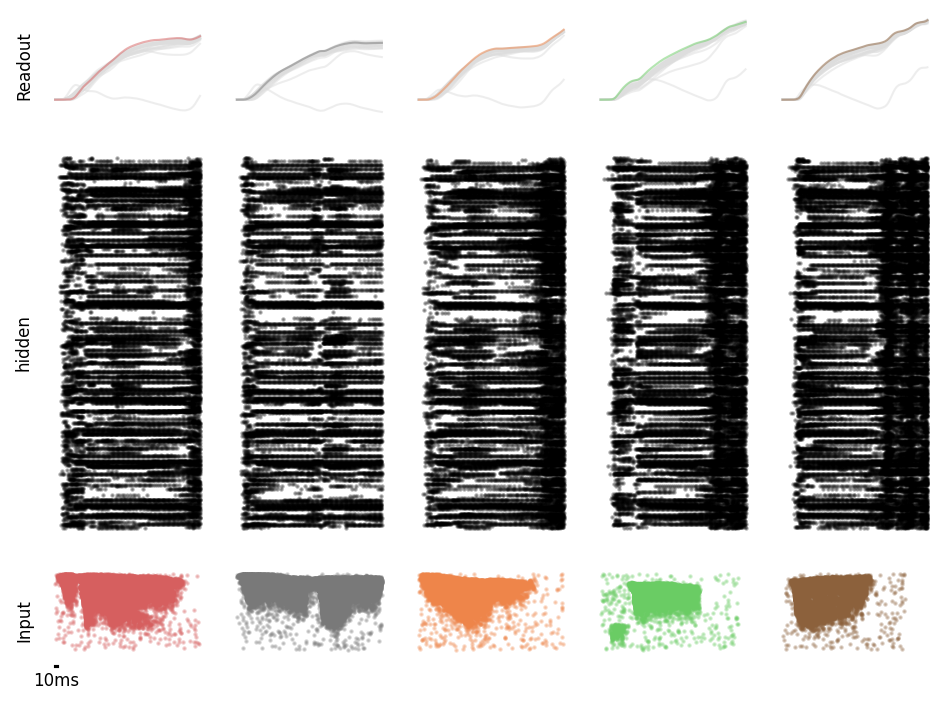

In [ ]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model, data=test_dataset, nb_samples=5, point_alpha=0.3
)